<a href="https://colab.research.google.com/github/ttobaegi/TimeSeries/blob/main/Dacon_Competition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

평가산식 : MAE(Mean Absolute Error)

Public 평가 : 전체 Test 데이터 중 무작위 30% (15일)

Private 평가 : 전체 Test 데이터 중 나머지 100% (35일)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Module Import

In [ ]:
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 

#!pip install catboost
#!pip install pycaret
#from pycaret.regression import *

import statsmodels.api as sm
from math import sqrt

from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

from tensorflow import keras
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Load

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dacon/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/sample_submission.csv')

# 원본데이터
df_train = train.copy()
df_test = test.copy()

## Feature Engineering

### Feature Generation

#### 요일변수 추가

In [ ]:
# 요일, 휴일정보 추가
train['일자']=pd.to_datetime(train['일자'])     # 날짜형변환
train['년']=train['일자'].dt.strftime('%Y')     # 년
train['월']=train['일자'].dt.strftime('%m')     # 월
train['요일']=train['일자'].dt.dayofweek        # 요일
train['일'] = train['일자'].dt.day              # 일
train['주']=train['일자'].dt.weekofyear         # 주

# 요일, 휴일정보 추가
test['일자']=pd.to_datetime(test['일자']) # 날짜형변환
test['년']=test['일자'].dt.strftime('%Y')    # 년
test['월']=test['일자'].dt.strftime('%m')   # 월
test['요일']=test['일자'].dt.dayofweek    # 요일
test['일'] = test['일자'].dt.day
test['주']=test['일자'].dt.weekofyear    # 주

# 메뉴 컬럼 삭제
train = train.filter(regex='일|년|월|주|본사|계')
test = test.filter(regex='일|년|월|주|본사|계')

# 컬럼 영문화
en_colnames = ['date','weekofday','total','off','btrip','night','wfh', 'ln','dn','year','month','day','week']
train.columns = en_colnames
en_test_colnames = ['date','weekofday','total','off','btrip','night','wfh','year','month','day', 'week']
test.columns = en_test_colnames

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


#### 식사 가능자 수 office

In [ ]:
# 식사가능자 수 office
train['office']= train['total']- train['btrip']-train['off']-train['wfh']
test['office']= test['total']- test['btrip']-test['off']-test['wfh']
train.head(2)

,date,weekofday,total,off,btrip,night,wfh,ln,dn,year,month,day,week,office
0,2016-02-01,0,2601,50,150,238,0.0,1039.0,331.0,2016,02,1,5,2401.0
1,2016-02-02,1,2601,50,173,319,0.0,867.0,560.0,2016,02,2,5,2378.0


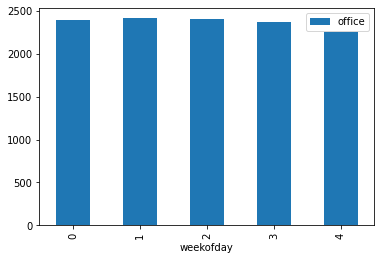

In [ ]:
train.groupby('weekofday').mean().filter(regex='office').plot.bar()

식사 가능자 office 변수 : 요일별 편차 크지 않음

실제 식수 인원과 식사 가능자 수 변수 간의 상관관계는?

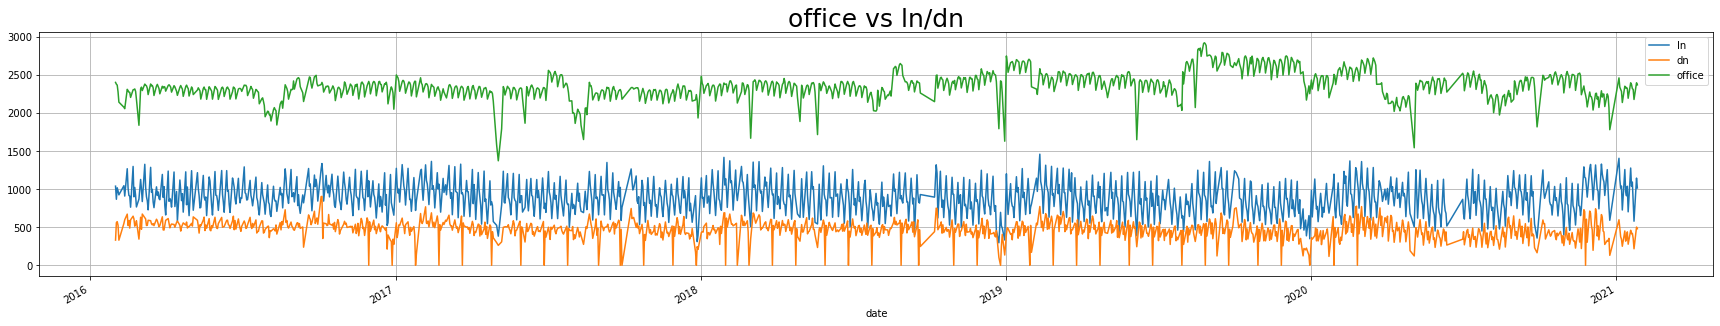

In [ ]:
train[['date', 'ln', 'dn','office']].plot(x = 'date', y = ['ln', 'dn','office'], figsize = (30, 5), grid = True)
plt.title('office vs ln/dn', fontsize = 25)
plt.show()

In [ ]:
train.filter(regex='ln|dn|office').corr().apply(lambda x : abs(x)).sort_values('ln', ascending=False).style.background_gradient('Blues')

,ln,dn,office
ln,1.000000,0.508287,0.286810
dn,0.508287,1.000000,0.172373
office,0.286810,0.172373,1.000000


##### 날짜 관련 변수 형변환 
(단순회귀)

In [ ]:
# tree model - label encoding
# 월 label encoding
train = train.astype({'month':'int','week':'int', 'weekofday':'int', 'day':'int', 'year':'int'})
test = test.astype({'month':'int','week':'int', 'weekofday':'int','day':'int', 'year':'int'})

In [ ]:
# 단순 회귀
import statsmodels.api as sm
# target variable ln/dn
train_y1 = train[['ln']]
train_y2 = train[['dn']]

In [ ]:
# total & office & 상수항
train_x1 = sm.add_constant(train[['total', 'off', 'btrip', 'night', 'wfh',
                                  'year', 'month', 'day', 'week', 'weekofday']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     312.8
Date:                Tue, 20 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:19:34   Log-Likelihood:                -7374.7
No. Observations:                1205   AIC:                         1.477e+04
Df Residuals:                    1194   BIC:                         1.483e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.97e+04   8722.087      4.552      0.0

In [ ]:

# office & 상수항
# total & office & 상수항
train_x1 = sm.add_constant(train[['total', 'off', 'btrip', 'night', 'wfh', 'office',
                                  'year', 'month', 'day', 'week', 'weekofday']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     312.8
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:15:31   Log-Likelihood:                -7374.7
No. Observations:                1205   AIC:                         1.477e+04
Df Residuals:                    1194   BIC:                         1.483e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.97e+04   8722.087      4.552      0.0

office가 모델 성능 향상에 크게 영향을 미치지 않는 것 같음

In [ ]:
train.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln',
       'dn', 'year', 'month', 'day', 'week', 'office'],
      dtype='object')

#### 요일별 평균 식수 인원 (train 데이터의)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


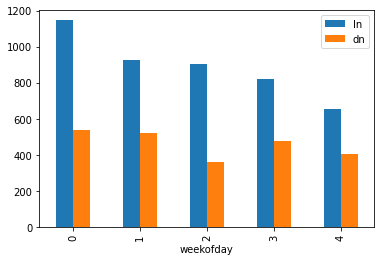

In [ ]:
# 요일별 평균 y
train.groupby('weekofday').mean().filter(regex='ln|dn').plot.bar()

##### 전체기간 요일평균

In [ ]:
avg_weekofday = train.groupby(['month','week','weekofday']).mean().apply(lambda x : round(x,0)).filter(regex='ln|dn')
avg_weekofday.reset_index(inplace=True)
avg_weekofday = avg_weekofday.rename(columns={'ln':'avg_ln','dn':'avg_dn'})

In [ ]:
# 전체 기간 요일 평균 함수 생성
def avg_ln(weekofday):
    if weekofday ==0: avg_weekofday = 1146
    elif weekofday ==1: avg_weekofday =  926
    elif weekofday ==2: avg_weekofday = 905
    elif weekofday ==3: avg_weekofday = 824
    else : avg_weekofday = 654      
    return avg_weekofday

def avg_dn(weekofday):
  if weekofday ==0: avg_weekofday = 540
  elif weekofday ==1: avg_weekofday =  520
  elif weekofday ==2: avg_weekofday = 364
  elif weekofday ==3: avg_weekofday = 480
  else : avg_weekofday = 405      
  return avg_weekofday

In [ ]:
train['avg_weekofday_ln']= train['weekofday'].apply(lambda x : avg_ln(x))
train['avg_weekofday_dn']= train['weekofday'].apply(lambda x : avg_dn(x))
test['avg_weekofday_ln']= train['weekofday'].apply(lambda x : avg_ln(x))
test['avg_weekofday_dn']= train['weekofday'].apply(lambda x : avg_dn(x))

In [ ]:
import statsmodels.api as sm

train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
# total & office & 상수항
train_x1 = sm.add_constant(train[['total', 'off', 'btrip', 'night', 'wfh', 'year', 'month', 'day', 'week', 'office', 
                                  'avg_weekofday_ln','avg_weekofday_dn']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     347.1
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:15:23   Log-Likelihood:                -7285.1
No. Observations:                1205   AIC:                         1.459e+04
Df Residuals:                    1193   BIC:                         1.466e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.188e+04   8228.907  

##### 동기간 요일평균
- 2016~2019
- 2020~2021

구분 이유 : 코로나

In [ ]:
#train=train[['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln','dn', 'year', 'month', 'day', 'week', 'office']]
#train=train[['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'year', 'month', 'day', 'week', 'office']]

In [ ]:
avg_weekofday_beforeCovid = train.query('year=="2016"|year=="2017"|year=="2018"|year=="2019"').groupby(['month','week','weekofday']).mean().apply(lambda x : round(x,0))[['ln','dn']]
avg_weekofday_afterCovid = train.query('year=="2020"|year=="2021"').groupby(['month','week','weekofday']).mean().apply(lambda x : round(x,0))[['ln','dn']]
avg_weekofday_beforeCovid.reset_index(inplace=True)
avg_weekofday_afterCovid.reset_index(inplace=True)
avg_weekofday_beforeCovid = avg_weekofday_beforeCovid.rename(columns={'ln':'avg_ln','dn':'avg_dn'})
avg_weekofday_afterCovid = avg_weekofday_afterCovid.rename(columns={'ln':'avg_ln','dn':'avg_dn'})

In [ ]:
beforeCovid = train.query('year=="2016"|year=="2017"|year=="2018"|year=="2019"').merge(avg_weekofday_beforeCovid, how='left', on=['month','week','weekofday'])
afterCovid = train.query('year=="2020"|year=="2021"').merge(avg_weekofday_beforeCovid, how='left', on=['month','week','weekofday'])

In [ ]:
train = pd.concat([beforeCovid,afterCovid]).reset_index(drop=True)
test = test.merge(avg_weekofday_afterCovid, how='left', on=['month','week','weekofday'])

In [ ]:
# 코로나 이전/이후 동기간(주,요일) 불일치로 결측치 발생, 전체기간 평균으로 대치
train['avg_ln'].fillna(train['avg_weekofday_ln'],inplace=True)
train['avg_dn'].fillna(train['avg_weekofday_dn'],inplace=True)
test['avg_ln'].fillna(test['avg_weekofday_ln'],inplace=True)
test['avg_dn'].fillna(test['avg_weekofday_dn'],inplace=True)

In [ ]:
train.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln',
       'dn', 'year', 'month', 'day', 'week', 'office', 'avg_weekofday_ln',
       'avg_weekofday_dn', 'avg_ln', 'avg_dn'],
      dtype='object')

In [ ]:
# 단순 회귀
import statsmodels.api as sm
# target variable ln/dn
train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
train_x1 = sm.add_constant(train[['week', 'total', 'off', 'btrip', 'night', 'wfh', 'month', 'day', 
                                  'office',  
                                  'avg_ln', 'avg_dn']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     506.1
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:15:41   Log-Likelihood:                -7152.0
No. Observations:                1205   AIC:                         1.433e+04
Df Residuals:                    1194   BIC:                         1.438e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        850.8920     60.897     13.973      0.0

**전체기간 요일평균만 포함한 단순회귀식이 더 R^2 높다**

In [ ]:
train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
# total & office & 상수항
train_x1 = sm.add_constant(train[['total', 'off', 'btrip', 'night', 'wfh', 'year', 'month', 'week', 'office',
                                  'avg_ln', 'avg_dn', 
                                  'avg_weekofday_ln','avg_weekofday_dn']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     435.2
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:17:39   Log-Likelihood:                -7135.8
No. Observations:                1205   AIC:                         1.430e+04
Df Residuals:                    1192   BIC:                         1.436e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.798e+04   7336.587  

둘 다 쓰기로 함

#### 전주(학습)/전년도동기간(테스트) 식사 가능자 수

In [ ]:
train['week'] = train['date'].apply(lambda x : pd.Timestamp(x).week)
test['week'] = test['date'].apply(lambda x : pd.Timestamp(x).week)

In [ ]:
before_ln = train.pivot_table(index=['year','week'], columns ='weekofday', values='ln', aggfunc='mean').reset_index(drop=True)

In [ ]:
# 학습용 데이터 
# 전체기간 주별 평균
a1 = train['ln'][3:-2].to_list()
a2 = train['dn'][3:-2].to_list()

# 전주 식수 데이터
b1 = train.avg_weekofday_ln[:5].to_list()
b2 = train.avg_weekofday_dn[:5].to_list()

# 전주 식수
b1.extend(a1)
b2.extend(a2)

# 피쳐 생성 : 학습용 데이터에는 바로 전주 식수 데이터를 적용
train['before_ln'] = b1
train['before_dn'] = b2

테스트 데이터에는 전주 식수 데이터를 계산하기 어려우므로, 전녀도 동기간 데이터를 불러온다

In [ ]:
# 전년도 동기간 데이터 불러오기 위해 2020 년 데이터 필터
lastyear = train.query('year=="2020"').reset_index(drop=True)

# 월, 주, 요일 기준으로 테스트 데이터 머지
before_test = test.merge(lastyear[['month','week','weekofday','ln','dn']], on=['month','week','weekofday'], how='left')

# 피쳐 생성 : 테스트 데이터에는 전년도 동기간 식수 데이터 : before_ln, before_dn
before_test = before_test.rename(columns={'ln':'before_ln','dn':'before_dn'})
before_test['before_ln'].fillna(test['avg_weekofday_ln'], inplace = True)
before_test['before_dn'].fillna(test['avg_weekofday_dn'], inplace = True)
test = before_test.copy()

In [ ]:
# 피쳐 체크
print(train.shape)
print(test.shape)

In [ ]:
# 단순 회귀
import statsmodels.api as sm
# target variable ln/dn
train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
train_x1 = sm.add_constant(train[['week', 'total', 'off', 'btrip', 'night', 'wfh', 'month', 'day','year',
                                  'office',  
                                  'avg_ln', 'avg_dn', 'avg_weekofday_ln','avg_weekofday_dn',
                                  'before_ln','before_dn']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

In [ ]:
def avg_ln(weekofday):
    if weekofday ==0: avg_weekofday = 1146
    elif weekofday ==1: avg_weekofday =  926
    elif weekofday ==2: avg_weekofday = 905
    elif weekofday ==3: avg_weekofday = 824
    else : avg_weekofday = 654      
    return avg_weekofday

def avg_dn(weekofday):
  if weekofday ==0: avg_weekofday = 540
  elif weekofday ==1: avg_weekofday =  520
  elif weekofday ==2: avg_weekofday = 364
  elif weekofday ==3: avg_weekofday = 480
  else : avg_weekofday = 405      
  return avg_weekofday

In [ ]:
# 요일 원핫 인코딩
# one-hot encode input variables
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)

#### 연휴 연말 변수

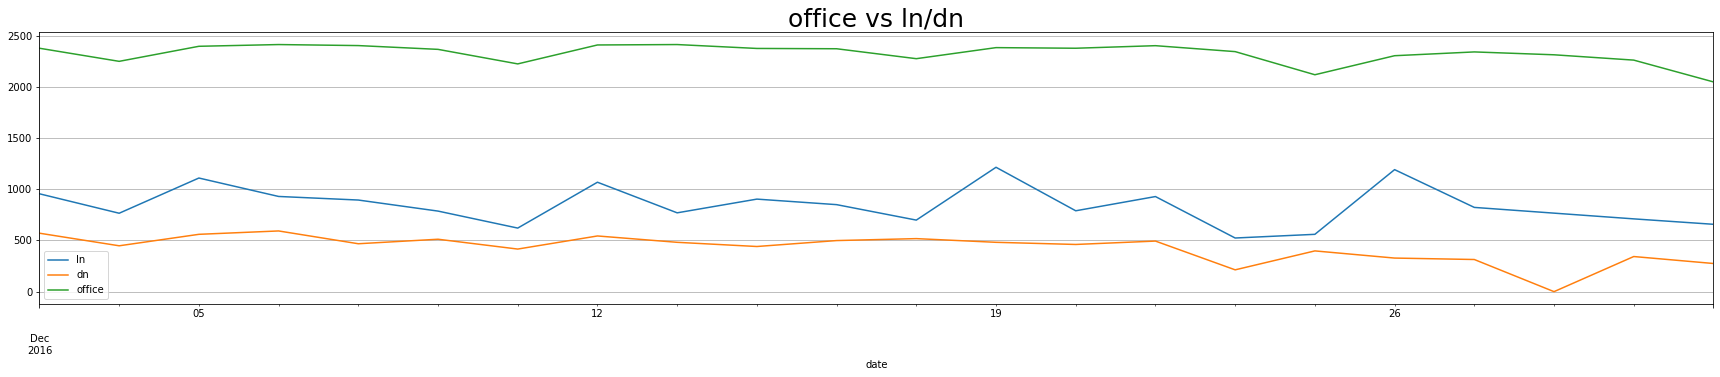

In [ ]:
train.query('year==2016&((month==1)|(month==12))')[['date', 'ln', 'dn','office']].plot(x = 'date', y = ['ln', 'dn','office'], figsize = (30, 5), grid = True)
plt.title('office vs ln/dn', fontsize = 25)
plt.show()

#### 전날 다음날 휴일 변수

In [ ]:
from datetime import timedelta, datetime

In [ ]:
!pip install pytimekr
from pytimekr import pytimekr

# 연도별 추석 날짜 구하기
holiday = []
for i in range(2016, 2022):
    holiday.append(pytimekr.hangul(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.children(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.independence(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.memorial(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.buddha(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.samiljeol(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.chuseok(i).strftime("%Y-%m-%d"))
    holiday.append(pytimekr.lunar_newyear(i).strftime("%Y-%m-%d"))

# holiday 리스트 str > datetime 형으로 변환    
holiday=pd.to_datetime(holiday, format="%Y-%m-%d")

  Created wheel for pytimekr: filename=pytimekr-0.1.0-py3-none-any.whl size=7941 sha256=e3a68d166434e0c90582e12051973d020fc075d186bc9cac745e5ae183aa8bb5
  Stored in directory: /root/.cache/pip/wheels/7c/54/31/d099bce210ce51c45eeb97e149699dedc66c78eb84c01be9c2
Successfully built pytimekr


In [ ]:
# holiday 앞뒤 날짜
holiday_next = holiday + timedelta(1)
holiday_before = holiday + timedelta(-1)

# 월요일 금요일 & holiday 앞뒤날짜
holiday_around = train[(train.weekofday.isin([0,4]))|(train.date.isin(holiday_next))|(train.date.isin(holiday_before))].date.to_list()

In [ ]:
holiday_around.extend(['2016-12-26','2017-12-26','2018-12-26','2019-12-26','2020-12-26',
                       '2016-12-24','2017-12-24','2018-12-24','2019-12-24','2020-12-24',
                       '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
                        '2020-01-23','2020-01-24','2020-01-27',
                        '2019-09-11', '2019-09-12', '2019-09-13', 
                        '2019-02-04', '2019-02-06',
                        '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
                        '2018-02-14', '2018-02-15', '2018-02-16', 
                        '2017-10-03','2017-10-04', '2017-10-05', '2017-10-06',
                       '2017-01-26','2017-01-27',
                       '2016-09-13','2016-09-14','2016-09-16',
                       '2016-02-09', '2016-02-10',
                       '2021-02-09','2021-02-10'])

In [ ]:
train['holiday'] = np.where(train.date.isin(holiday_around),1,0)
test['holiday'] = np.where(test.date.isin(holiday_around),1,0)

In [ ]:
# 단순 회귀
import statsmodels.api as sm
# target variable ln/dn
train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
train_x1 = sm.add_constant(train[['week', 'total', 'off', 'btrip', 'night', 'wfh', 'month', 'day', 
                                  'office',  'year',
                                  'avg_ln', 'avg_dn', 'avg_weekofday_ln','avg_weekofday_dn',
                                  'before_ln','before_dn',
                                  'holiday',
                                  'event']])
model1 = sm.OLS(train_y1, train_x1)
result1 = model1.fit()
print(result1.summary())

#### 이벤트 변수

In [ ]:
# 매월 마지막주 수요일 석식계 == 0
train['event'] = np.where(train.date.isin(train.query('dn==0').date.to_list()),1,0)

In [ ]:
test['event'] = np.where(test.date.isin(test.query('(weekofday==2)&((day==27)|(month==2)&(day==24)|(day==31))').date),1,0)

In [ ]:
# 단순 회귀
import statsmodels.api as sm
# target variable ln/dn
train_y1 = train[['ln']]
train_y2 = train[['dn']]
# office & 상수항
train_x1 = sm.add_constant(train[['week', 'total', 'off', 'btrip', 'night', 'wfh', 'month', 'day', 
                                  'office',  'year',
                                  'avg_ln', 'avg_dn', 'avg_weekofday_ln','avg_weekofday_dn',
                                  'before_ln','before_dn',
                                  'holiday',
                                  'event']])
model1 = sm.OLS(train_y2, train_x1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     dn   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     289.1
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:18:51   Log-Likelihood:                -6670.5
No. Observations:                1205   AIC:                         1.338e+04
Df Residuals:                    1187   BIC:                         1.347e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.256e+04   5158.299  

In [ ]:
train.query('event==1')

,date,weekofday,total,off,btrip,night,wfh,ln,dn,year,month,day,week,office,avg_weekofday_ln,avg_weekofday_dn,avg_ln,avg_dn,holiday,before_ln,before_dn,event
204,2016-11-30,2,2689,68,207,0,0.0,1109.0,0.0,2016,11,30,48,2414.0,905,364,902.0,0.0,0,1246.0,623.0,1
224,2016-12-28,2,2705,166,225,0,0.0,767.0,0.0,2016,12,28,52,2314.0,905,364,678.0,0.0,0,1192.0,328.0,1
244,2017-01-25,2,2697,79,203,0,0.0,720.0,0.0,2017,1,25,4,2415.0,905,364,841.0,222.0,0,1152.0,509.0,1
262,2017-02-22,2,2632,75,252,0,0.0,1065.0,0.0,2017,2,22,8,2305.0,905,364,1045.0,377.0,0,1216.0,648.0,1
281,2017-03-22,2,2627,53,235,0,0.0,953.0,0.0,2017,3,22,12,2339.0,905,364,994.0,360.0,0,1328.0,556.0,1
306,2017-04-26,2,2626,45,304,0,0.0,835.0,0.0,2017,4,26,17,2277.0,905,364,937.0,122.0,0,1109.0,531.0,1
327,2017-05-31,2,2637,43,265,0,0.0,910.0,0.0,2017,5,31,22,2329.0,905,364,894.0,0.0,0,1193.0,555.0,1
346,2017-06-28,2,2648,58,259,0,0.0,745.0,0.0,2017,6,28,26,2331.0,905,364,867.0,122.0,0,1147.0,539.0,1
366,2017-07-26,2,2839,254,246,0,0.0,797.0,0.0,2017,7,26,30,2339.0,905,364,793.0,186.0,0,1119.0,486.0,1
392,2017-09-01,4,2642,177,303,45,0.0,663.0,0.0,2017,9,1,35,2162.0,654,405,748.0,230.0,1,898.0,395.0,1


In [ ]:
test.query('event==1')

,date,weekofday,total,off,btrip,night,wfh,year,month,day,week,office,avg_weekofday_ln,avg_weekofday_dn,avg_ln,avg_dn,holiday,before_ln,before_dn,event
0,2021-01-27,2,2983,88,182,5,358.0,2021,1,27,4,2355.0,1146,540,782.0,354.0,0,782.0,354.0,1
18,2021-02-24,2,2924,77,235,3,234.0,2021,2,24,8,2378.0,905,364,930.0,434.0,0,930.0,434.0,1
42,2021-03-31,2,2975,86,217,0,317.0,2021,3,31,13,2355.0,926,520,1022.0,526.0,0,1022.0,526.0,1


## Multi step forecasting

### Correlation

In [ ]:
train.corr().filter(regex='ln|dn').apply(lambda x : abs(x)).sort_values('ln', ascending=False).style.background_gradient('Blues')

,ln,dn
ln,1.000000,0.508287
weekofday,0.734273,0.313240
night,0.535611,0.571168
btrip,0.512680,0.188164
dn,0.508287,1.000000
off,0.391975,0.316894
office,0.286810,0.172373
month,0.154664,0.127142
total,0.115529,0.173852
day,0.097392,0.185565


**본사정원수, 현본사소속재택근무자수 drop**

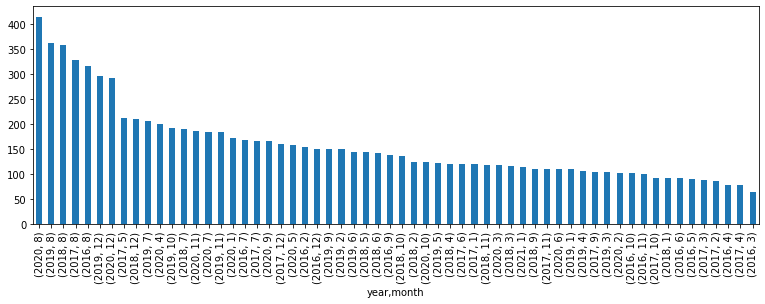

In [ ]:
train.groupby(['year','month']).mean()['off'].sort_values(ascending=False).plot.bar(figsize=(13,4))

### Features1

In [ ]:
train1 = train.drop(['total','wfh'], axis = 1)
test1 = test.drop(['total','wfh'], axis = 1)

X = train1.drop(['year','month','ln','dn'], axis=1).values
y1 = train1['ln'].values
y2 = train1['dn'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.1, random_state=10)

In [ ]:
np.random.seed(10)

# define the model
hyper_params_rf = {
    "n_estimators": 1000,
    "random_state" : np.random.seed(10)
}

model = RandomForestRegressor(**hyper_params)

# fit the model

model.fit(X_train, y1_train)

# get importance
features = features1
importances = model.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(model.feature_importances_, index=features1)
feat_importances

In [ ]:
features1

Index(['요일', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '월', '본사근무자수'], dtype='object')

In [ ]:
hyper_params_rf = {
    "n_estimators": 1000,
    "random_state" : np.random.seed(10)
}
hyper_params_gbm = {'n_estimators': 150, 
                    'max_depth': 5, 
                    'random_state': np.random.seed(10),
                    'min_samples_leaf' : 10, 
                    'learning_rate': 0.05, 
                    'subsample': 0.7, 
                    'loss': 'ls'}

                    # 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

models = [['RandomForest', RandomForestRegressor(**hyper_params_rf)], 
          ['XGBoost', XGBRegressor()], 
          ['LightGBM', LGBMRegressor(**hyper_params_gbm)]]

best_loss_mae = np.inf

for i, (name, model) in enumerate(models):
    model.fit(X_train, y1_train)
    y_pred = model.predict(X_test)
    current_loss_mae = mean_absolute_error(y1_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = round(current_loss_mae,3)
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
      
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')


## Submission 1

In [ ]:
train.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln',
       'dn', 'year', 'month', 'day', 'office', 'avg_ln', 'avg_dn', 'week',
       'before_ln', 'before_dn', 'diff'],
      dtype='object')

In [ ]:
train1 = train.drop(['date','total','year'], axis = 1)
test1 = test.drop(['date','total','year'], axis = 1)
train1.head(2)

,weekofday,off,btrip,night,wfh,ln,dn,month,day,office,avg_ln,avg_dn,week,before_ln,before_dn,diff
0,0,50,150,238,0.0,1039.0,331.0,2,1,2401.0,1146,540,5,1146.0,540.0,-107.0
1,1,50,173,319,0.0,867.0,560.0,2,2,2378.0,926,520,5,926.0,520.0,-59.0


In [ ]:
ln_df = train1.drop('dn',axis=1)
dn_df = train1.drop('ln',axis=1)

In [ ]:
ln_df.head()

,weekofday,off,btrip,night,wfh,ln,month,day,office
0,0,50,150,238,0.0,1039.0,2,1,2401.0
1,1,50,173,319,0.0,867.0,2,2,2378.0
2,2,56,180,111,0.0,1017.0,2,3,2365.0
3,3,104,220,355,0.0,978.0,2,4,2277.0
4,4,278,181,34,0.0,925.0,2,5,2142.0


In [ ]:
# tree model - label encoding
# 월 label encoding
ln_df = ln_df.astype({'ln':'int'})
dn_df = dn_df.astype({'dn':'int'})

In [ ]:
from pycaret.regression import *

# initialize setup
ln_reg = setup(ln_df, 
               target='ln',
               categorical_features=['day','month'],
               train_size = 0.2,
               normalize = True)


,Description,Value
0,session_id,4008
1,Target,ln
2,Original Data,"(1205, 9)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(241, 53)"


In [ ]:
comp = compare_models(sort = 'mae')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,79.2093,11118.8598,104.4823,0.7227,0.1244,0.0953,1.472
lasso,Lasso Regression,79.5207,11264.3113,105.1181,0.7243,0.1239,0.0942,0.017
gbr,Gradient Boosting Regressor,79.8880,11279.6859,105.1079,0.7233,0.1247,0.0952,0.082
rf,Random Forest Regressor,80.0407,11538.5109,105.9402,0.7197,0.1261,0.0957,0.484
omp,Orthogonal Matching Pursuit,80.4780,11770.3432,107.0971,0.7140,0.1263,0.0956,0.017
br,Bayesian Ridge,80.9647,11555.9972,106.5363,0.7181,0.1266,0.0963,0.019
par,Passive Aggressive Regressor,81.4023,11872.9402,107.3389,0.7124,0.1267,0.0959,0.016
huber,Huber Regressor,81.6353,11687.1886,106.8163,0.7147,0.1294,0.0977,0.049
ridge,Ridge Regression,83.0719,12055.6680,108.8429,0.7050,0.1304,0.0992,0.018
llar,Lasso Least Angle Regression,83.8954,12596.2670,110.7234,0.6984,0.1316,0.1009,0.019


In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 7.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=b7356043e3db01b879c82e0e487f7b53f1644d47f000672d0f65896e785c1892
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,57.3876,4619.9220,67.9700,0.8127,0.0790,0.0676
1,67.7917,9714.8830,98.5641,0.7210,0.1182,0.0849
2,81.3933,10658.4630,103.2398,0.7559,0.1396,0.1067
3,78.0679,9568.9706,97.8211,0.7834,0.1037,0.0861
4,95.3775,14530.0246,120.5406,0.6536,0.1458,0.1144
5,70.6000,9232.5802,96.0863,0.7480,0.1060,0.0804
6,98.1242,13770.8634,117.3493,0.7752,0.1317,0.1099
7,75.3200,11951.3080,109.3220,0.6470,0.1598,0.1146
8,105.3558,19436.9828,139.4166,0.5344,0.1689,0.1221
9,70.9887,11901.1111,109.0922,0.7658,0.1085,0.0704


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


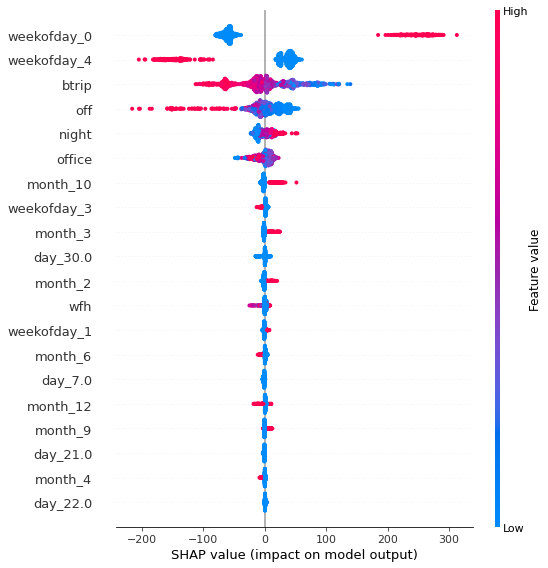

In [ ]:
interpret_model(create_model('rf'))

- 월요일일수록 중식계 높음
- 금요일일수록 중식계 낮음

In [ ]:
# initialize setup
ln_reg = setup(dn_df, 
               target='dn',
               categorical_features=['day','month'],
               train_size = 0.2,
               normalize = True)

,Description,Value
0,session_id,5410
1,Target,dn
2,Original Data,"(1205, 8)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(241, 22)"


In [ ]:
comp = compare_models(sort = 'mae')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,61.7365,9.580577e+03,90.8725,0.4635,0.6355,0.1247,0.026
par,Passive Aggressive Regressor,62.7960,9.773970e+03,91.7952,0.4530,0.6378,0.1266,0.014
gbr,Gradient Boosting Regressor,63.7702,9.749286e+03,92.8532,0.4251,0.6479,0.1306,0.049
rf,Random Forest Regressor,64.7306,9.503142e+03,92.1468,0.4206,0.6482,0.1356,0.407
lasso,Lasso Regression,64.8820,9.570293e+03,92.1603,0.4384,0.6361,0.1331,0.014
br,Bayesian Ridge,65.0392,9.668969e+03,92.6387,0.4346,0.6394,0.1332,0.015
ridge,Ridge Regression,65.4818,9.790790e+03,93.2969,0.4234,0.6391,0.1333,0.013
lr,Linear Regression,65.8018,9.901337e+03,93.9008,0.4143,0.6407,0.1342,0.013
et,Extra Trees Regressor,67.4516,1.059743e+04,98.4606,0.3233,0.6778,0.1443,0.389
knn,K Neighbors Regressor,67.4571,1.063119e+04,97.4520,0.3499,0.6582,0.1427,0.060


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,68.7263,8369.4733,91.4848,0.3492,0.2166,0.1581
1,111.2601,29827.5566,172.7066,0.1775,1.7304,0.1859
2,79.4718,9513.0501,97.5349,0.3444,0.1915,0.1640
3,60.2870,9740.9856,98.6964,0.5912,1.2211,0.1439
4,61.1859,4817.6667,69.4094,0.5405,0.1497,0.1300
5,70.6794,12631.2665,112.3889,0.1951,1.2540,0.1189
6,58.3973,4601.8945,67.8373,0.3357,0.1521,0.1286
7,69.7921,6973.6389,83.5083,0.1361,0.1914,0.1547
8,78.8144,15636.0026,125.0440,0.3091,1.2735,0.1768
9,59.7278,5364.9500,73.2458,0.3159,0.1818,0.1411


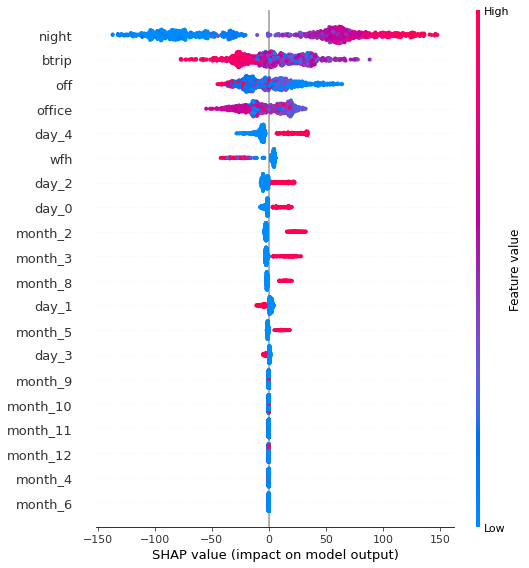

In [ ]:
interpret_model(create_model('lightgbm'))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
hyper_params_rf = {
    "n_estimators": 1000,
    "random_state" : np.random.seed(10)
}
hyper_params_gbm = {'n_estimators': 1000, 
                    'max_depth': 5, 
                    'random_state': np.random.seed(10),
                    'num_leaves' : 10, 
                    'learning_rate': 0.05, 
                    'subsample': 0.7, 
                    'boosting' : 'rf'
                    'loss': 'ls'}

                    # 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 


models = [['RandomForest', RandomForestRegressor(**hyper_params_rf)], 
          ['XGBoost', XGBRegressor()], 
          ['LightGBM', LGBMRegressor(**hyper_params_gbm)]]

best_loss_mae = np.inf

for i, (name, model) in enumerate(models):
    model.fit(X_train, y1_train)
    y_pred = model.predict(X_test)
    current_loss_mae = mean_absolute_error(y1_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = round(current_loss_mae,3)
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
      
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')


RandomForest Model Mean Absolute Error: 68.281
[12:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Model Mean Absolute Error: 65.267
[LightGBM] [Warning] Unknown parameter: loss
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
LightGBM Model Mean Absolute Error: 65.267
Best Model (MAE기준): XGBoost, MAE : 65.267


In [ ]:
best_model = LGBMRegressor(**hyper_params_gbm)
best_model.fit(X, y1)
pred1 = best_model.predict(test3.values)
best_model.fit(X, y2)
pred2 = best_model.predict(test3.values)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/sample_submission.csv')

In [ ]:
submission['중식계'] = pred1
submission['석식계'] = pred2
submission.head()

,일자,중식계,석식계
0,2021-01-27,1067.935503,326.856732
1,2021-01-28,994.823282,504.047743
2,2021-01-29,584.690218,198.465403
3,2021-02-01,1272.392121,443.702293
4,2021-02-02,1048.733824,392.896954


In [ ]:
submission.to_csv('/content/drive/MyDrive/dacon/data/submission1.csv', index=False)

Month 변수 제외

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

### Target Variable 분포 

In [ ]:
# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.



 mu = 890.33 and sigma = 209.42



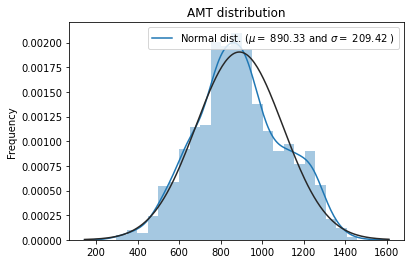

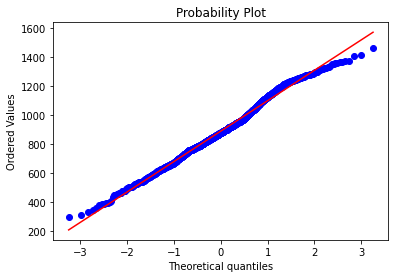

In [ ]:
sns.distplot(y1 , fit=norm);
(mu, sigma) = norm.fit(y1)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y1, plot=plt)
plt.show()

# RandomForest

## ln :: GridSearchCV

In [ ]:
train.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln',
       'dn', 'year', 'month', 'day', 'week', 'office', 'avg_ln', 'avg_dn'],
      dtype='object')

In [ ]:
test.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'year',
       'month', 'day', 'week', 'office', 'avg_ln', 'avg_dn'],
      dtype='object')

In [ ]:
train1 = train.drop(['date'], axis = 1)
test1 = test.drop(['date'], axis = 1)

X = train1.drop(['ln','dn'], axis=1).values
y1 = train1['ln'].values
y2 = train1['dn'].values

,weekofday,total,off,btrip,night,wfh,ln,dn,year,month,day,week,office,avg_ln,avg_dn
0,0,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,5,2401.0,1039.0,331.0
1,1,2601,50,173,319,0.0,867.0,560.0,2016,2,2,5,2378.0,867.0,560.0


In [ ]:
X = train1.drop(['ln','dn'], axis=1).values
y1 = train1['ln'].values
y2 = train1['dn'].values

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(np.array(X))
X_test_scaled = scaler.fit_transform(np.array(test1))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

param_grid = {
    "n_estimators":[100,500,1000],
    "max_depth":[10, 30, 50],
    "max_features":[6,8,10,12,14,16],
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X, y1)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed: 24.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### ln :: Permutation Importance

In [ ]:
!pip install eli5
import eli5 
from eli5.sklearn import PermutationImportance 

     |████████████████████████████████| 112kB 4.9MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X = train1.drop(['ln','dn','date'], axis=1)
test_forpredict = test1.drop(['day','season'], axis=1)
y1 = train1[['ln']]
y2 = train1[['dn']]

X_train, X_test, y1_train, y1_test = train_test_split( X.values, y1.values, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split( X.values, y2.values, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=30, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
# model fitting
rf.fit(X_train,y1_train)

# Permutation Importance
permutation = PermutationImportance(rf, scoring = "neg_mean_absolute_error", random_state = 42).fit(X_test, y1_test) 
eli5.show_weights(permutation, feature_names = train1.drop(['ln','dn','date'], axis=1).columns.tolist())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Weight,Feature
58.2883 ± 1.9403,avg_ln
7.2470 ± 1.6043,btrip
6.7892 ± 1.2779,weekofday
6.5600 ± 1.9945,avg_weekofday_ln
3.9247 ± 0.7887,off
3.0272 ± 2.2072,night
2.5028 ± 1.9480,avg_weekofday_dn
2.0655 ± 0.7375,avg_dn
1.8538 ± 0.6857,year
1.3357 ± 0.3955,office


In [ ]:
train1.columns

Index(['weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln', 'dn',
       'year', 'month', 'day', 'week', 'office', 'avg_ln', 'avg_dn', 'holiday',
       'season'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# model fitting
rf.fit(X_train,y1_train)
# prediction
pred1 = rf.predict(X_test)
mean_absolute_error(y1_test,pred1)

66.71947513812154

In [ ]:
X = train1.drop(['ln','dn','day','season'], axis=1).values
y1 = train1['ln'].values
y2 = train1['dn'].values

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split( X, y2, test_size=0.3, random_state=42)

In [ ]:
# model fitting
rf.fit(X_train,y1_train)
# prediction
pred1 = rf.predict(X_test)
mean_absolute_error(y1_test,pred1)

66.27709944751382

In [ ]:
rf.fit(X_train, y1_train, eval_set=[(X_test, y1_test)],
        scoring='neg_mean_absolute_error',  early_stopping_rounds=1000)

### ln:: Feature Selection & Prediction 1

In [ ]:
ln_X = train1.drop(['ln','dn'], axis=1).values
#ln_X_train_scaled = scaler.fit_transform(np.array(ln_X))

ln_X_test = test1.values
#ln_X_test_scaled = scaler.fit_transform(np.array(ln_X_test))

y1 = train1['ln'].values

rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
# Training
rf.fit(ln_X,y1)

# Prediction
pred1 = rf.predict(ln_X_test)

In [ ]:
submission['중식계'] = np.round(pred1, 0)
submission.head(2)

,일자,중식계,석식계
0,2021-01-27,895.0,0
1,2021-01-28,852.0,0


In [ ]:
train1.drop(['ln','dn','day','wfh'], axis=1).columns

Index(['weekofday', 'off', 'btrip', 'night', 'month', 'office', 'avg_ln',
       'avg_dn', 'week'],
      dtype='object')

### dn :: GridSearchCV

In [ ]:
param_grid = {
    "n_estimators":[100,500,1000],
    "max_depth":[10, 30, 50],
    "max_features":[6,8,10,12,14,16],
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train_scaled, y2)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed: 11.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### dn :: Permutation Importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=30, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
# model fitting
rf.fit(X_train,y2_train)

# Permutation Importance
permutation = PermutationImportance(rf, scoring = "neg_mean_absolute_error", random_state = 42).fit(X_test, y2_test) 
eli5.show_weights(permutation, feature_names = train1.drop(['ln','dn','day','season'], axis=1).columns.tolist())

Weight,Feature
35.6750 ± 4.2514,avg_dn
11.3270 ± 4.7039,night
5.9463 ± 1.1118,year
2.6129 ± 1.0450,off
1.7810 ± 0.5754,total
1.4449 ± 0.3622,wfh
1.2486 ± 0.6481,btrip
1.1261 ± 0.4907,avg_ln
0.6952 ± 0.9560,weekofday
0.4566 ± 0.5441,office


In [ ]:
# model fitting
rf.fit(X_train,y2_train)
# prediction
pred2 = rf.predict(X_test)
mean_absolute_error(y2_test,pred2)

52.19592541436464

In [ ]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=16, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
# Training
rf.fit(X,y2)

# Prediction
dn_X_test = test.drop(['date'], axis = 1)
#dn_X_test_scaled = scaler.fit_transform(np.array(test1))

pred2 = rf.predict(dn_X_test)

In [ ]:
permutation = PermutationImportance(rf, scoring = "neg_mean_absolute_error", random_state = 42).fit(X, y2) 
eli5.show_weights(permutation, feature_names = train1.drop(['ln','dn'], axis=1).columns.tolist())

Weight,Feature
48.1585 ± 2.6496,avg_dn
14.1658 ± 1.2695,night
8.5495 ± 0.7046,year
4.3964 ± 0.8246,day
3.8322 ± 0.1151,off
2.9947 ± 0.3248,btrip
2.8233 ± 0.2118,total
2.7568 ± 0.1581,weekofday
2.6978 ± 0.0926,avg_ln
1.9388 ± 0.2306,office


Feature Drop없이 예측

In [ ]:
submission['석식계'] = np.round(pred2, 0)
submission.head(2)

,일자,중식계,석식계
0,2021-01-27,895.0,250.0
1,2021-01-28,852.0,381.0


In [ ]:
submission.to_csv('/content/drive/MyDrive/dacon/data/submission9.csv', index=False)

# CATBOOST

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 69.2 MB 4.9 kB/s 


In [ ]:
train.head(1)

,date,weekofday,total,off,btrip,night,wfh,ln,dn,year,month,day,week,office,avg_weekofday_ln,avg_weekofday_dn,avg_ln,avg_dn,before_ln,before_dn,holiday,event
0,2016-02-01,0,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,5,2401.0,1146,540,1039.0,331.0,1146.0,540.0,1,0


In [ ]:
train1 = train1.astype({'month':'int','week':'int', 'weekofday':'int', 'day':'int', 'year':'int'})
test1 = test1.astype({'month':'int','week':'int', 'weekofday':'int','day':'int', 'year':'int'})

NameError: ignored

# LN 

In [ ]:
train.columns

Index(['date', 'weekofday', 'total', 'off', 'btrip', 'night', 'wfh', 'ln',
       'dn', 'year', 'month', 'day', 'week', 'office', 'avg_weekofday_ln',
       'avg_weekofday_dn', 'avg_ln', 'avg_dn', 'before_ln', 'before_dn',
       'holiday', 'event'],
      dtype='object')

In [ ]:
'week', 'total', 'off', 'btrip', 'night', 'wfh', 'month', 'day', 
                                  'office',  'year',
                                  'avg_ln', 'avg_dn', 'avg_weekofday_ln','avg_weekofday_dn',
                                  'before_ln','before_dn',
                                  'holiday',
                                  'event'

In [ ]:
train1 = train.drop(['date','event'], axis = 1)
test1 = test.drop(['date','event'], axis = 1)

X = train1.drop(['ln','dn'], axis=1)
y1 = train1['ln']
y2 = train1['dn']

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.3, random_state=42)

cat_features =['month','day','year','weekofday']
catb1 = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=1000, 
         learning_rate=0.05, 
         random_state=42,
    )   
catb1.fit(X_train, y1_train, 
          eval_set = (X_test,y1_test), 
          use_best_model=True,
          verbose=100)

0:	learn: 162.0408056	test: 159.4832862	best: 159.4832862 (0)	total: 5.99ms	remaining: 5.99s
100:	learn: 53.3248769	test: 64.2301656	best: 64.2301656 (100)	total: 569ms	remaining: 5.07s
200:	learn: 41.9616737	test: 61.7516777	best: 61.7062777 (195)	total: 1.08s	remaining: 4.3s
300:	learn: 34.8010393	test: 61.2724026	best: 61.2705925 (291)	total: 1.6s	remaining: 3.72s
400:	learn: 30.2162507	test: 60.9647217	best: 60.8774799 (386)	total: 2.12s	remaining: 3.16s
500:	learn: 27.0216365	test: 60.9267145	best: 60.7826017 (425)	total: 2.62s	remaining: 2.61s
600:	learn: 24.4159508	test: 60.9426368	best: 60.7826017 (425)	total: 3.13s	remaining: 2.08s
700:	learn: 22.3945240	test: 61.0076766	best: 60.7826017 (425)	total: 3.62s	remaining: 1.54s
800:	learn: 20.8114128	test: 60.8473625	best: 60.7826017 (425)	total: 4.13s	remaining: 1.03s
900:	learn: 19.6130398	test: 60.6646227	best: 60.6606048 (898)	total: 4.65s	remaining: 511ms
999:	learn: 18.5611934	test: 60.7562397	best: 60.6353055 (943)	total: 5.

event 는 ln과 상관이 없으니 제외하도록함

In [ ]:
train1 = train.drop(['date','event','before_ln','before_dn'], axis = 1)
test1 = test.drop(['date','event','before_ln','before_dn'], axis = 1)

X = train1.drop(['ln','dn'], axis=1)
y1 = train1['ln']
y2 = train1['dn']

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.3, random_state=42)

cat_features =['weekofday','month','holiday','day']
catb1 = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE'
         
    )   
catb1.fit(X_train, y1_train, 
          eval_set = (X_test,y1_test), 
          use_best_model=True,
          verbose=100)

0:	learn: 164.6818733	test: 162.0628720	best: 162.0628720 (0)	total: 5.42ms	remaining: 5.41s
100:	learn: 63.5007911	test: 70.1356106	best: 70.1356106 (100)	total: 441ms	remaining: 3.93s
200:	learn: 51.5630550	test: 65.1635551	best: 65.1635551 (200)	total: 866ms	remaining: 3.44s
300:	learn: 44.8674325	test: 62.9999432	best: 62.9907230 (299)	total: 1.32s	remaining: 3.06s
400:	learn: 39.4348505	test: 62.2194201	best: 62.2185666 (399)	total: 1.77s	remaining: 2.65s
500:	learn: 35.8328707	test: 61.5720139	best: 61.5720139 (500)	total: 2.24s	remaining: 2.23s
600:	learn: 32.4688296	test: 61.4877319	best: 61.4877319 (600)	total: 2.68s	remaining: 1.78s
700:	learn: 29.9768566	test: 61.4233406	best: 61.4233406 (700)	total: 3.14s	remaining: 1.34s
800:	learn: 27.8382977	test: 61.4875186	best: 61.4185549 (746)	total: 3.57s	remaining: 888ms
900:	learn: 25.9109651	test: 61.4262140	best: 61.4130988 (822)	total: 4.03s	remaining: 443ms
999:	learn: 24.3872745	test: 61.4490615	best: 61.4014357 (961)	total: 

Text(0.5, 0, 'CatBoost Feature Importance')

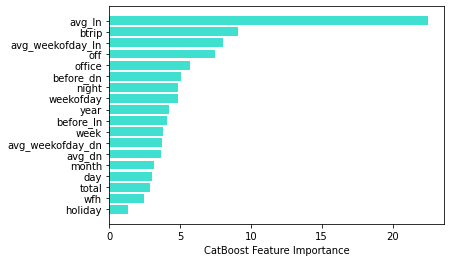

In [ ]:
sorted_feature_importance = catb1.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        catb1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
catb1.fit(X,y1,
          use_best_model=True,
          verbose=100)

catb1.predict(test1)
pred1 = np.round(catb1.predict(test1),0)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 161.3177582	total: 5.79ms	remaining: 5.78s
100:	learn: 55.0828827	total: 541ms	remaining: 4.82s
200:	learn: 45.3008232	total: 1.09s	remaining: 4.36s
300:	learn: 38.8741303	total: 1.63s	remaining: 3.79s
400:	learn: 35.1860953	total: 2.18s	remaining: 3.26s
500:	learn: 32.1828853	total: 2.73s	remaining: 2.72s
600:	learn: 29.7768956	total: 3.29s	remaining: 2.18s
700:	learn: 28.0268861	total: 3.85s	remaining: 1.64s
800:	learn: 26.5552945	total: 4.38s	remaining: 1.09s
900:	learn: 25.3885983	total: 4.93s	remaining: 542ms
999:	learn: 24.2943483	total: 5.46s	remaining: 0us


# DN

In [ ]:
train1 = train.drop(['date'], axis = 1)
test1 = test.drop(['date'], axis = 1)

X = train1.drop(['ln','dn'], axis=1)
y1 = train1['ln']
y2 = train1['dn']

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.3, random_state=42)

cat_features =['month','day','holiday','year','event','weekofday','year']
catb2 = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=1000, 
         learning_rate=0.05, 
         random_state=42,
    )   
catb2.fit(X_train, y2_train, 
          eval_set = (X_test,y2_test), 
          use_best_model=True,
          verbose=100)

0:	learn: 96.2869503	test: 93.9551095	best: 93.9551095 (0)	total: 6.27ms	remaining: 6.26s
100:	learn: 38.0047648	test: 43.5670128	best: 43.5670128 (100)	total: 484ms	remaining: 4.31s
200:	learn: 29.1672551	test: 41.1263572	best: 41.1263572 (200)	total: 1s	remaining: 3.99s
300:	learn: 23.7525587	test: 40.9686794	best: 40.9210113 (296)	total: 1.53s	remaining: 3.56s
400:	learn: 20.2715582	test: 41.0733694	best: 40.9113073 (351)	total: 2.07s	remaining: 3.09s
500:	learn: 17.8941645	test: 41.0568219	best: 40.9113073 (351)	total: 2.58s	remaining: 2.57s
600:	learn: 15.8835677	test: 41.0744370	best: 40.9113073 (351)	total: 3.09s	remaining: 2.05s
700:	learn: 14.4804741	test: 41.1137264	best: 40.9113073 (351)	total: 3.59s	remaining: 1.53s
800:	learn: 13.2585852	test: 41.1528195	best: 40.9113073 (351)	total: 4.1s	remaining: 1.02s
900:	learn: 12.2264929	test: 41.1317128	best: 40.9113073 (351)	total: 4.61s	remaining: 506ms
999:	learn: 11.3091590	test: 41.0875584	best: 40.9113073 (351)	total: 5.11s	r

Text(0.5, 0, 'CatBoost Feature Importance')

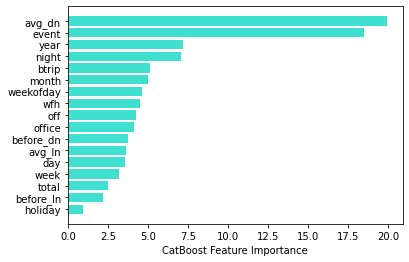

In [ ]:
sorted_feature_importance = catb2.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        catb2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
train2 = train.drop(['date','avg_weekofday_ln','avg_weekofday_dn'], axis = 1)
test2 = test.drop(['date','avg_weekofday_ln','avg_weekofday_dn'], axis = 1)

X = train2.drop(['ln','dn'], axis=1)
y1 = train2['ln']
y2 = train2['dn']

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.3, random_state=42)

cat_features =['month','day','holiday','year','event','weekofday','year']
catb2 = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=1000, 
         learning_rate=0.05, 
         random_state=42,
    )   
catb2.fit(X_train, y2_train, 
          eval_set = (X_test,y2_test), 
          use_best_model=True,
          verbose=100)

0:	learn: 96.5018376	test: 94.5719603	best: 94.5719603 (0)	total: 5.46ms	remaining: 5.45s
100:	learn: 37.5223520	test: 44.3013900	best: 44.3013900 (100)	total: 489ms	remaining: 4.35s
200:	learn: 28.4473570	test: 41.5572870	best: 41.5572870 (200)	total: 991ms	remaining: 3.94s
300:	learn: 23.3628382	test: 41.2257850	best: 41.1962627 (282)	total: 1.51s	remaining: 3.51s
400:	learn: 20.0392787	test: 41.0997288	best: 41.0685430 (353)	total: 2.02s	remaining: 3.02s
500:	learn: 17.6121116	test: 40.9601723	best: 40.9221732 (476)	total: 2.53s	remaining: 2.52s
600:	learn: 15.8598622	test: 41.0538577	best: 40.9044223 (515)	total: 3.06s	remaining: 2.03s
700:	learn: 14.4861693	test: 40.9441468	best: 40.9044223 (515)	total: 3.58s	remaining: 1.53s
800:	learn: 13.3667626	test: 40.9301205	best: 40.8771706 (722)	total: 4.11s	remaining: 1.02s
900:	learn: 12.4658950	test: 40.8444227	best: 40.8264203 (884)	total: 4.62s	remaining: 507ms
999:	learn: 11.6920574	test: 40.8554915	best: 40.8264203 (884)	total: 5.1

In [ ]:
catb2.fit(X,y2,
          use_best_model=True,
          verbose=100)

catb2.predict(test2)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 95.2294180	total: 7.31ms	remaining: 7.31s
100:	learn: 38.8272929	total: 553ms	remaining: 4.92s
200:	learn: 31.9633316	total: 1.12s	remaining: 4.47s
300:	learn: 27.6010908	total: 1.68s	remaining: 3.91s
400:	learn: 24.6600301	total: 2.22s	remaining: 3.32s
500:	learn: 22.2714050	total: 2.75s	remaining: 2.74s
600:	learn: 20.5730336	total: 3.32s	remaining: 2.21s
700:	learn: 19.0927087	total: 3.86s	remaining: 1.65s
800:	learn: 17.8458825	total: 4.42s	remaining: 1.1s
900:	learn: 16.7923659	total: 4.96s	remaining: 546ms
999:	learn: 15.9707970	total: 5.5s	remaining: 0us


array([ 88.23796907, 338.90503154, 254.82918922, 482.22371859,
       429.00079768, 358.74665886, 394.10367033, 410.35536516,
       526.75556711, 412.69826509, 201.46493068, 688.19194409,
       661.23608371, 382.40599215, 512.80886947, 314.01037793,
       661.01561834, 588.29044278, 134.21636444, 482.75710261,
       231.40871558, 601.26257761, 423.06035718, 442.21611097,
       317.58433461, 659.90007391, 632.95122894, 383.14674101,
       549.47073396, 282.96813951, 689.75114437, 582.98065745,
       398.81215785, 512.60816095, 261.45985199, 651.00023646,
       537.5898225 , 340.60227774, 457.54373901, 251.2917437 ,
       630.95267954, 607.42110084, 216.7644362 , 323.20322451,
       250.54025337, 493.47845687, 538.41176253, 458.60195486,
       504.94807128, 256.55481377])

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/sample_submission.csv')

In [ ]:
submission['일자'] = pd.to_datetime(submission['일자'])

In [ ]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [ ]:
event_date = test.query('event==1').date.to_list()
submission[submission.일자.isin(event_date)]

In [ ]:
submission['일자'] = pd.to_datetime(submission['일자'])
submission10['일자'] = pd.to_datetime(submission10['일자'])

In [ ]:
submission['석식계'] = np.where(submission.일자.isin(event_date),0,pred2)

In [ ]:
# 자기계발의 날은 석식이 없기 때문에 0으로 보정
submission10['석식계'] = np.where(submission10.일자.isin(event_date),0,submission10.석식계)

In [ ]:
np.where(submission10.일자.isin(event_date),0,submission10.석식계)

array([  0., 374., 251., 394., 514., 516., 518., 331., 621., 446., 323.,
       675., 601., 382., 518., 374., 660., 587.,   0., 504., 318., 480.,
       559., 501., 410., 661., 619., 483., 547., 404., 691., 544., 437.,
       493., 290., 642., 580., 339., 463., 313., 635., 585.,   0., 335.,
       442., 622., 495., 425., 482., 296.])

In [ ]:
submission.to_csv('/content/drive/MyDrive/dacon/data/submission21.csv', index=False)

In [ ]:
# 결과물 비교해보기
# pd.concat([submission,submission10], keys='일자', axis=1)

일                         자               
           일자     중식계    석식계         일자     중식계    석식계
0  2021-01-27   980.0    0.0 2021-01-27   881.0  360.0
1  2021-01-28   882.0  337.0 2021-01-28   849.0  374.0
2  2021-01-29   797.0  239.0 2021-01-29   625.0  251.0
3  2021-02-01   926.0  499.0 2021-02-01  1157.0  394.0
4  2021-02-02   823.0  420.0 2021-02-02   871.0  514.0
5  2021-02-03   804.0  373.0 2021-02-03  1012.0  516.0
6  2021-02-04   745.0  410.0 2021-02-04   981.0  518.0
7  2021-02-05   879.0  369.0 2021-02-05   736.0  331.0
8  2021-02-08  1082.0  549.0 2021-02-08  1282.0  621.0
9  2021-02-09   914.0  403.0 2021-02-09  1070.0  446.0
10 2021-02-10   669.0  173.0 2021-02-10   833.0  323.0
11 2021-02-15  1089.0  676.0 2021-02-15  1302.0  675.0
12 2021-02-16  1199.0  708.0 2021-02-16  1087.0  601.0
13 2021-02-17  1038.0  389.0 2021-02-17  1029.0  382.0
14 2021-02-18   808.0  544.0 2021-02-18   915.0  518.0
15 2021-02-19   678.0  323.0 2021-02-19   669.0  374.0
16 2021-02-22  1143.0  657.0 2021-02-22  1294.0  660.0
17 2021-02-23  1059.0  629.0 2021-02-23  1028.0  587.0
18 2021-02-24   827.0    0.0 2021-02-24   977.0  343.0
19 2021-02-25   809.0  499.0 2021-02-25   893.0  504.0
20 2021-02-26   578.0  273.0 2021-02-26   584.0  318.0
21 2021-03-02  1173.0  672.0 2021-03-02   829.0  480.0
22 2021-03-03   894.0  410.0 2021-03-03  1020.0  559.0
23 2021-03-04   930.0  480.0 2021-03-04   997.0  501.0
24 2021-03-05   729.0  334.0 2021-03-05   675.0  410.0
25 2021-03-08  1178.0  696.0 2021-03-08  1305.0  661.0
26 2021-03-09  1175.0  712.0 2021-03-09  1082.0  619.0
27 2021-03-10   976.0  374.0 2021-03-10  1018.0  483.0
28 2021-03-11   932.0  579.0 2021-03-11   954.0  547.0
29 2021-03-12   639.0  276.0 2021-03-12   692.0  404.0
30 2021-03-15  1128.0  702.0 2021-03-15  1314.0  691.0
31 2021-03-16  1167.0  620.0 2021-03-16  1040.0  544.0
32 2021-03-17   994.0  404.0 2021-03-17  1025.0  437.0
33 2021-03-18   862.0  557.0 2021-03-18   886.0  493.0
34 2021-03-19   609.0  253.0 2021-03-19   633.0  290.0
35 2021-03-22  1130.0  643.0 2021-03-22  1251.0  642.0
36 2021-03-23  1042.0  582.0 2021-03-23  1003.0  580.0
37 2021-03-24   831.0  357.0 2021-03-24   955.0  339.0
38 2021-03-25   812.0  477.0 2021-03-25   920.0  463.0
39 2021-03-26   614.0  251.0 2021-03-26   585.0  313.0
40 2021-03-29  1108.0  649.0 2021-03-29  1220.0  635.0
41 2021-03-30  1107.0  634.0 2021-03-30  1038.0  585.0
42 2021-03-31   977.0    0.0 2021-03-31  1006.0  365.0
43 2021-04-01   851.0  375.0 2021-04-01   955.0  335.0
44 2021-04-02   700.0  305.0 2021-04-02   627.0  442.0
45 2021-04-05   952.0  514.0 2021-04-05  1241.0  622.0
46 2021-04-06  1133.0  584.0 2021-04-06   899.0  495.0
47 2021-04-07   929.0  444.0 2021-04-07   930.0  425.0
48 2021-04-08   921.0  517.0 2021-04-08   873.0  482.0
49 2021-04-09   660.0  230.0 2021-04-09   632.0  296.0

In [ ]:
!pip install shap 
import shap

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491631 sha256=3b8ebb5366c2ef4b24b49e706521ea4e1f09e6d10484ce9f5267949b48dba831
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


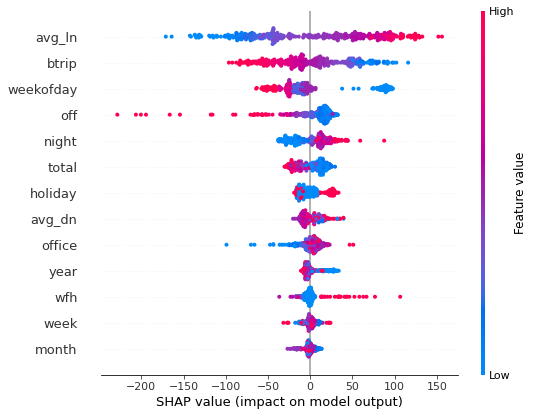

In [ ]:
explainer = shap.TreeExplainer(catb1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Text(0.5, 0, 'CatBoost Feature Importance')

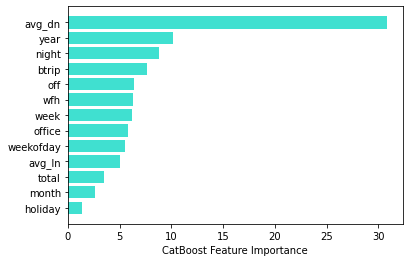

In [ ]:
sorted_feature_importance = catb2.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        catb2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
catb2.predict(test_forpredict)

array([413.73126334, 402.83098783, 160.65904495, 442.28807749,
       421.35915255, 361.18184553, 410.8125789 , 227.89408234,
       544.75218133, 465.99608489, 198.57275129, 686.23767383,
       591.16288616, 429.05924485, 471.2783903 , 303.10849549,
       625.2259499 , 571.5771402 , 370.86969267, 466.97237745,
       254.98045777, 557.71667577, 423.44192229, 532.71302022,
       315.925074  , 659.11444725, 598.40019934, 448.41340693,
       519.95931758, 285.16268663, 684.13612706, 567.3186087 ,
       462.1706663 , 482.05488242, 217.22074054, 627.01742275,
       541.68290205, 374.52239228, 471.24197715, 212.02988549,
       619.69846295, 586.24213179, 465.90047086, 443.42801785,
       327.63548727, 566.22739973, 540.36115672, 455.71256871,
       501.92677897, 206.45205085])

In [ ]:
from catboost import CatBoostRegressor
cat_features =['weekofday','year','month']
catb1 = CatBoostRegressor(
             cat_features=cat_features,

         loss_function='MAE',
         n_estimators=1000, 
         learning_rate=0.05, 
         random_state=42
    )
catb2 = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=1000, 
         learning_rate=0.05, 
         random_state=42
    )

#ln_X = train1.drop(['ln','dn'], axis=1).values
    
catb1.fit(train1.drop(['ln','dn'], axis=1),train[['ln']],use_best_model=True ,verbose=100)
catb2.fit(train1.drop(['ln','dn'], axis=1),train[['dn']],use_best_model=True, verbose=100)


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 161.1438578	total: 4.76ms	remaining: 4.76s
100:	learn: 55.5903010	total: 447ms	remaining: 3.98s
200:	learn: 46.1285702	total: 902ms	remaining: 3.58s
300:	learn: 41.0148480	total: 1.36s	remaining: 3.17s
400:	learn: 37.4509146	total: 1.81s	remaining: 2.7s
500:	learn: 34.9086561	total: 2.26s	remaining: 2.25s
600:	learn: 32.6143967	total: 2.72s	remaining: 1.8s
700:	learn: 30.8888906	total: 3.17s	remaining: 1.35s
800:	learn: 29.4966175	total: 3.63s	remaining: 901ms
900:	learn: 28.3436356	total: 4.08s	remaining: 449ms
999:	learn: 27.1385594	total: 4.52s	remaining: 0us
0:	learn: 95.8558496	total: 4.77ms	remaining: 4.76s


You should provide test set for use best model. use_best_model parameter has been switched to false value.


100:	learn: 42.2512340	total: 456ms	remaining: 4.06s
200:	learn: 34.6112670	total: 887ms	remaining: 3.52s
300:	learn: 30.1265667	total: 1.33s	remaining: 3.09s
400:	learn: 27.0707832	total: 1.8s	remaining: 2.69s
500:	learn: 24.8260916	total: 2.24s	remaining: 2.23s
600:	learn: 23.1148927	total: 2.69s	remaining: 1.79s
700:	learn: 21.8584820	total: 3.13s	remaining: 1.34s
800:	learn: 20.4707092	total: 3.59s	remaining: 892ms
900:	learn: 19.4001980	total: 4.03s	remaining: 443ms
999:	learn: 18.5492773	total: 4.49s	remaining: 0us


In [ ]:
pred1 = catb1.predict(test_forpredict)
pred2 = catb2.predict(test_forpredict)
submission['중식계'] = np.round(pred1, 0)
submission['석식계'] = np.round(pred2, 0)
submission

### 교차 검증 & 하이퍼파라미터 및 튜닝

In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [ ]:
# 교차검증 수행
def get_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_absolute_error", cv = 5)
  cv_model.fit(X_train, y_train)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test)
  eval_pred = np.expm1(eval_pred)
  
  return cv_model.best_estimator_


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
train3.drop(['dn','ln'],axis=1).columns

Index(['weekofday', 'off', 'btrip', 'night', 'wfh', 'day', 'office'], dtype='object')

In [ ]:
X = train.drop(['date','dn','ln'],axis=1).values
y1 = train['ln'].values
y2 = train['dn'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.2, random_state=126, shuffle=True)
X_train.shape, y1_train.shape, X_test.shape, y1_test.shape


((964, 16), (964,), (241, 16), (241,))

In [ ]:

# 4개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000],'learning_rate':[ 0.05]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

NameError: ignored

In [ ]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)
gbm_pred = gbm_reg.predict(X_test)
lgb_pred = lgb_reg.predict(X_test)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(3, 241)
(241, 3)


In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test, final)

Test Data RMSLE: 1.020


In [ ]:
test3 = test.drop(['date','total','year','month'], axis = 1).values
X_test = test3

In [ ]:
# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)

gbm_pred = gbm_reg.predict(X_test)

lgb_pred = lgb_reg.predict(X_test)


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/sample_submission.csv')

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
submission['중식계'] = np.round(final, 0)

In [ ]:
X = train3.drop(['dn','ln'],axis=1).values
y1 = ln_df['ln'].values
y2 = dn_df['dn'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y2_train, y2_test = train_test_split( X, y2, test_size=0.2, random_state=126, shuffle=True)
X_train.shape, y1_train.shape, X_test.shape, y1_test.shape

y_train = y2_train
y_test= y2_test

# 4개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)

gbm_pred = gbm_reg.predict(X_test)

lgb_pred = lgb_reg.predict(X_test)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test, final)




[17:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
test3 = test.drop(['date','total','year','month'], axis = 1).values
X_test = test3

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)

gbm_pred = gbm_reg.predict(X_test)

lgb_pred = lgb_reg.predict(X_test)

final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
submission['석식계'] = np.round(final, 0)

In [ ]:
submission.to_csv('/content/drive/MyDrive/dacon/data/submission2.csv', index=False)

## Modeling3

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
# Independent Variables
train4 = train.drop(['date','total','year','month'], axis = 1)
test4 = test.drop(['date','total','year','month'], axis = 1)

ln_df = train4.drop('dn',axis=1)
dn_df = train4.drop('ln',axis=1)
features4 = ln_df.columns
print(f'features4 = {ln_df.columns}')

features4 = Index(['weekofday', 'off', 'btrip', 'night', 'wfh', 'ln', 'day', 'office'], dtype='object')


In [ ]:
# Split into features and targets (ln,dn)
X = train4.drop(['dn','ln'],axis=1)
y1 = ln_df['ln']
y2 = dn_df['dn']

# y1 : ln
from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.2, random_state=10)
X_train, X_test, y2_train, y2_test = train_test_split( X, y2, test_size=0.2, random_state=10)

In [ ]:
#Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
X_train.shape

(964, 7)

In [ ]:
# define the model
# Experiment with deeper and wider networks
model = Sequential()
model.add(Dense(128, input_dim=7, activation='relu'))
model.add(Dense(64, activation='relu'))

#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model.fit(X_train_scaled, y1_train, validation_split=0.2, epochs =100)

Epoch 1/100
25/25 [==============================] - 1s 14ms/step - loss: 836082.1947 - mae: 891.0627 - val_loss: 826568.1875 - val_mae: 884.1736
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 819800.6875 - mae: 881.4048 - val_loss: 816280.0625 - val_mae: 878.4532
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 814980.3462 - mae: 878.1761 - val_loss: 795448.5625 - val_mae: 866.8331
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 807896.6659 - mae: 874.1052 - val_loss: 757007.5625 - val_mae: 845.2258
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 752188.5938 - mae: 843.4456 - val_loss: 694725.6250 - val_mae: 809.2039
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 695859.7452 - mae: 810.6073 - val_loss: 605788.7500 - val_mae: 754.7167
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 579061.0601 - mae: 735.5249 - val_loss: 493557.3125 - va

In [ ]:
history.params

{'epochs': 100, 'steps': 25, 'verbose': 1}

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


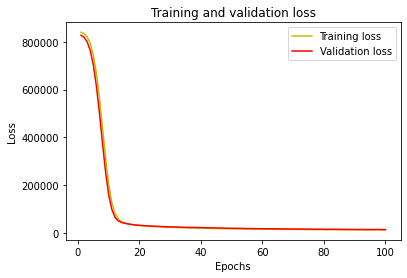

In [ ]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

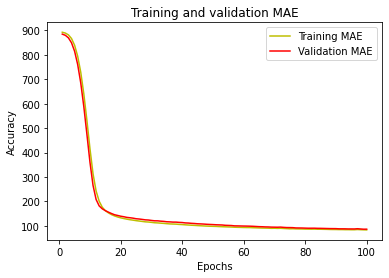

In [ ]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Predict on test data
predictions = model.predict(X_test_scaled)
print("Predicted values are: ", predictions[:5])
print("Real values are: ", y1_test[:5])

Predicted values are:  [[861.6295 ]
 [840.67285]
 [759.7094 ]
 [665.5478 ]
 [987.29675]]
Real values are:  123    829.0
907    785.0
862    813.0
426    567.0
730    679.0
Name: ln, dtype: float64


In [ ]:
#Comparison with other models..
#Neural network - from the current code
mse_neural, mae_neural = model.evaluate(X_test_scaled, y1_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

8/8 [==============================] - 0s 2ms/step - loss: 10480.0381 - mae: 79.7224
Mean squared error from neural net:  10480.0380859375
Mean absolute error from neural net:  79.72241973876953


In [ ]:
X_test_scaled = scaler.transform(test4)
pred3 = model.predict(X_test_scaled)

In [ ]:
pred3[:5]

array([[ 959.7069 ],
       [ 869.103  ],
       [ 740.68317],
       [1135.8296 ],
       [ 973.033  ]], dtype=float32)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/sample_submission.csv')
submission['중식계'] = np.round(pred3, 0)

In [ ]:
history2 = model.fit(X_train_scaled, y2_train, validation_split=0.2, epochs =100)
X_test_scaled = scaler.transform(test4)
pred4 = model.predict(X_test_scaled)
submission['석식계'] = np.round(pred4, 0)

Epoch 1/100
25/25 [==============================] - 0s 4ms/step - loss: 105750.9844 - mae: 271.7395 - val_loss: 23981.0293 - val_mae: 107.2950
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 15830.9521 - mae: 85.9132 - val_loss: 13913.6270 - val_mae: 84.0744
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 12609.3789 - mae: 78.4088 - val_loss: 13045.9004 - val_mae: 80.7283
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 11858.2207 - mae: 76.0370 - val_loss: 12358.6318 - val_mae: 77.5975
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 11294.3008 - mae: 74.0481 - val_loss: 11921.6260 - val_mae: 75.2902
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 11004.7422 - mae: 74.1743 - val_loss: 11611.6279 - val_mae: 75.1810
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 10641.6914 - mae: 72.7403 - val_loss: 11349.9883 - val_mae: 73.3290
Epoch 8/10

In [ ]:
#Random forest.
#Increase number of tress and see the effect
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 30, random_state=30)
model.fit(X_train_scaled, y_train)

y_pred_RF = model.predict(X_test_scaled)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error Using Random Forest: ', mae_RF)


In [ ]:
submission.head(2)

,일자,중식계,석식계
0,2021-01-27,960.0,394.0
1,2021-01-28,869.0,444.0


In [ ]:
submission.to_csv('/content/drive/MyDrive/dacon/data/submission3.csv', index=False)

## Modeling 2 

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV

In [ ]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)

# Generates 200 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='neg_mean_absolute_error')

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(X_train, y1_train)

In [ ]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

1.0

In [ ]:
# transform the df
# Instantiate Standard Scaler.

Z_test = pd.DataFrame(X_test, columns=features1)

In [ ]:
# Instantiate model.
ridge_opt = Ridge(alpha=ridge_optimal_alpha)

# Fit model.
ridge_opt.fit(X_train, y1_train)

# Generate predictions
ridge_opt_preds = ridge_opt.predict(X_test)
ridge_opt_preds_train = ridge_opt.predict(X_train)

# Evaluate model.
print(mean_absolute_error(y1_test, ridge_opt_preds))
print(mean_absolute_error(y1_train, ridge_opt_preds_train))

83.69880635472298
88.3042239649115


In [ ]:
s = setup(data = train, 
          test_data = test, 
          target = 'Passengers', 
          fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Series'], 
          fold = 3, 
          transform_target = True, 
          session_id = 123)


In [ ]:
best = compare_models(sort = 'MAE')


In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(**hyper_params)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test = train_test_split( X, y1, test_size=0.1, random_state=42)
gbm.fit(X_train, y1_train, eval_set=[(X_test, y1_test)],
        scoring='neg_mean_absolute_error',  early_stopping_rounds=1000)


TypeError: ignored

In [ ]:
y1_pred = gbm.predict(X, num_iteration=gbm.best_iteration_)
mean_absolute_error(y1, y1_pred)

167.0576230512584

# TimeSeries Check


In [ ]:
# Lookback period
lookback = 7
X_train, Y_train = create_dataset(df, lookback)
X_test, Y_test = create_dataset(test, lookback)

In [ ]:
df = train.filter(regex='요일|수|계')

In [ ]:
# stationarity 정상성
# ADF test 
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = train.set_index('일자').filter(regex='수|계')
df.head()


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
일자,,,,,,,
2016-02-01,2601,50,150,238,0.0,1039.0,331.0
2016-02-02,2601,50,173,319,0.0,867.0,560.0
2016-02-03,2601,56,180,111,0.0,1017.0,573.0
2016-02-04,2601,104,220,355,0.0,978.0,525.0
2016-02-05,2601,278,181,34,0.0,925.0,330.0


In [ ]:
# 하기 컬럼들에 대해서 정상성 TEST
df.columns

Index(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계',
       '석식계'],
      dtype='object')

In [ ]:
series1 = df.loc[:, '중식계'].values
series2= df.loc[:, '석식계'].values

In [ ]:
# ADF Test
# choose a the number of lags that yields the lowest AIC
result = adfuller(series2, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'n_lags: {result[2]}')
print('\n')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.937345820294474
p-value: 0.0017765615618916977
n_lags: 19


Critial Values:
   1%, -3.435880398285223
Critial Values:
   5%, -2.8639821109786747
Critial Values:
   10%, -2.5680702282397765


In [ ]:
for name, values in df.iteritems():
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    result = adfuller(df[name])

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        # H0 : the series is non-stationary 정상 시계열이 아니다  
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print('\n\n')

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.8597089253711174
p-value : 0.3512460716698079
#Lags Used : 22
Number of Observations Used : 1182
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.303631868285128
p-value : 1.3187826851148894e-10
#Lags Used : 11
Number of Observations Used : 1193
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.602674425580556
p-value : 0.00012771142647163784
#Lags Used : 13
Number of Observations Used : 1191
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.911208818091042
p-value : 1.2110727830802742e-09
#Lags Used : 9
Number of Observations Used : 1195
strong evidence against the null hypothesis, reject 

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:

### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,100)):
    model = VAR(endog=df.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)


BEST ORDER: 7 BEST AIC: 55.676984014520784


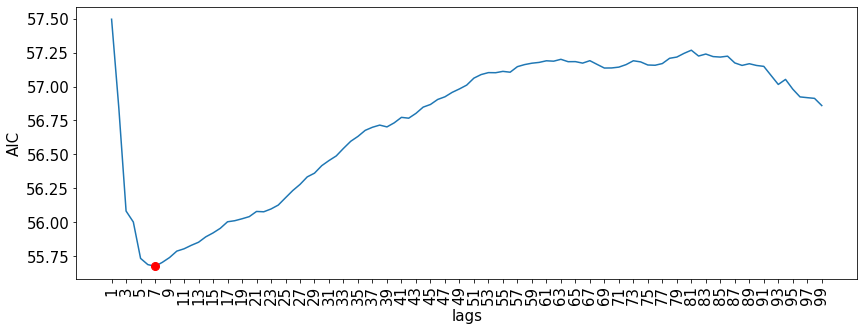

In [ ]:
### PLOT AICs ### 
plt.figure(figsize=(14 ,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
var.select_order(7).summary()

,AIC,BIC,FPE,HQIC
0,66.32,66.35,6.366e+28,66.33
1,57.51,57.75,9.466e+24,57.60
2,56.85,57.30,4.897e+24,57.02
3,56.09,56.74*,2.281e+24,56.33
4,56.00,56.87,2.100e+24,56.33
5,55.74,56.81,1.606e+24,56.14*
6,55.69,56.97,1.537e+24,56.17
7,55.68*,57.16,1.515e+24*,56.24


In [ ]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=df.values)
var_fitted = var.fit(maxlags=best_order)
var_fitted.aic

55.676984014520784